In [157]:
import SimpleITK as sitk
from PIL import Image
import torch
import torchvision
import os
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import PIL
import torchstat
from torchstat import stat
from thop import profile
from thop import clever_format
import math

In [158]:
input_bladder = os.listdir('H:/SingleVMAT/stack_split/bladder')
input_rectum = os.listdir('H:/SingleVMAT/stack_split/rectum')
input_feml = os.listdir('H:/SingleVMAT/stack_split/lfem')
input_femr = os.listdir('H:/SingleVMAT/stack_split/rfem')
input_SI = os.listdir('H:/SingleVMAT/stack_split/bowel')
input_PTV = os.listdir('H:/SingleVMAT/stack_split/PTV')

input_ct = os.listdir('H:/SingleVMAT/stack_split/CT')
output_label = os.listdir('H:/SingleVMAT/stack_split/RD')

input_bladder_list = []
input_rectum_list = []
input_feml_list = []
input_femr_list = []
input_SI_list = []
input_PTV_list = []


input_ct_list = []
output_label_list = []

for i in input_bladder:
    file_path = 'H:/SingleVMAT/stack_split/bladder/{}'.format(i)
    # print(input_mask_list)
    input_bladder_list.append(file_path)

for i in input_rectum:
    file_path = 'H:/SingleVMAT/stack_split/rectum/{}'.format(i)
    # print(input_mask_list)
    input_rectum_list.append(file_path)

for i in input_feml:
    file_path = 'H:/SingleVMAT/stack_split/lfem/{}'.format(i)
    # print(input_mask_list)
    input_feml_list.append(file_path)

for i in input_femr:
    file_path = 'H:/SingleVMAT/stack_split/rfem/{}'.format(i)
    # print(input_mask_list)
    input_femr_list.append(file_path)

for i in input_SI:
    file_path = 'H:/SingleVMAT/stack_split/bowel/{}'.format(i)
    # print(input_mask_list)
    input_SI_list.append(file_path)

for i in input_PTV:
    file_path = 'H:/SingleVMAT/stack_split/PTV/{}'.format(i)
    # print(input_mask_list)
    input_PTV_list.append(file_path)


for i in input_ct:
    file_path = 'H:/SingleVMAT/stack_split/CT/{}'.format(i)
    # print(input_ct_list)
    input_ct_list.append(file_path)

for i in output_label:
    file_path = 'H:/SingleVMAT/stack_split/RD/{}'.format(i)
    # print(output_label_list)
    output_label_list.append(file_path)
    

In [159]:
class D3UNetData(Dataset):
    def __init__(self,input_bladder_list,input_rectum_list,input_feml_list,input_femr_list,input_SI_list,input_PTV_list,input_ct_list,output_label_list,transformer):
        self.input_bladder_list = input_bladder_list
        self.input_rectum_list = input_rectum_list
        self.input_feml_list = input_feml_list
        self.input_femr_list = input_femr_list
        self.input_SI_list = input_SI_list
        self.input_PTV_list = input_PTV_list

        self.input_ct_list = input_ct_list
        self.output_label_list = output_label_list
        self.transformer = transformer

    def __getitem__(self, index):
        bladder = self.input_bladder_list[index]
        rectum = self.input_rectum_list[index]
        feml = self.input_feml_list[index]
        femr = self.input_femr_list[index]
        SI = self.input_SI_list[index]
        PTV = self.input_PTV_list[index]

        ct = self.input_ct_list[index]
        label = self.output_label_list[index]
        
        bladder_array = np.load(bladder).astype(np.float32)
        rectum_array = np.load(rectum).astype(np.float32)
        feml_array = np.load(feml).astype(np.float32)
        femr_array = np.load(femr).astype(np.float32)
        SI_array = np.load(SI).astype(np.float32)
        PTV_array = np.load(PTV).astype(np.float32)
    
        ct_array = np.load(ct).astype(np.float32)
        label_array = np.load(label).astype(np.float32)

        # mask_array = torch.FloatTensor(mask_array)
        # ct_array = torch.FloatTensor(ct_array)
        # label_array = torch.FloatTensor(label_array)

        bladder_array = self.transformer(bladder_array)
        rectum_array = self.transformer(rectum_array)
        feml_array = self.transformer(feml_array)
        femr_array = self.transformer(femr_array)
        SI_array = self.transformer(SI_array)
        PTV_array = self.transformer(PTV_array) 
 
        ct_array = self.transformer(ct_array)
        label_array = self.transformer(label_array)


        bladder_array = bladder_array.unsqueeze(0)
        rectum_array = rectum_array.unsqueeze(0)
        feml_array = feml_array.unsqueeze(0)
        femr_array = femr_array.unsqueeze(0)
        SI_array = SI_array.unsqueeze(0)
        PTV_array = PTV_array.unsqueeze(0)
  
        ct_array = ct_array.unsqueeze(0)
        input = torch.cat((bladder_array,rectum_array,feml_array,femr_array,SI_array,PTV_array,ct_array),0)
        label_array = label_array.unsqueeze(0)
        
        
        return input,label_array
    
    def __len__(self):
        return len(self.output_label_list)
    

In [160]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
])

data = D3UNetData(input_bladder_list,input_rectum_list,input_feml_list,input_femr_list,input_SI_list,input_PTV_list,input_ct_list,output_label_list,transformer = transformer)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dl, test_dl = torch.utils.data.random_split(data, [train_size, test_size])

train_dl = DataLoader(train_dl, shuffle = True, batch_size = 2)
test_dl = DataLoader(test_dl, shuffle = True, batch_size = 1)


In [161]:
class ResUNet_v3(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder_stage1 = nn.Sequential(
            nn.Conv3d(7, 16, 3, 1, padding=1),
            nn.InstanceNorm3d(16),
            nn.PReLU(16),

            nn.Conv3d(16, 16, 3, 1, padding=1),
            nn.InstanceNorm3d(16),
            nn.PReLU(16),
        )

        self.encoder_stage2 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),

            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),

            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),
        )

        self.encoder_stage3 = nn.Sequential(
            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1, ),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1, ),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),
        )

        self.encoder_stage4 = nn.Sequential(
            nn.Conv3d(128, 128, 3, 1, padding=1, ),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1, ),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1, ),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),
        )

        self.decoder_stage1 = nn.Sequential(
            nn.Conv3d(128, 256, 3, 1, padding=1),
            nn.InstanceNorm3d(256),
            nn.PReLU(256),

            nn.Conv3d(256, 256, 3, 1, padding=1),
            nn.InstanceNorm3d(256),
            nn.PReLU(256),

            nn.Conv3d(256, 256, 3, 1, padding=1),
            nn.InstanceNorm3d(256),
            nn.PReLU(256),
        )

        self.decoder_stage2 = nn.Sequential(
            nn.Conv3d(128 + 64, 128, 3, 1, padding=1),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),
        )

        self.decoder_stage3 = nn.Sequential(
            nn.Conv3d(64 + 32, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),
        )

        self.decoder_stage4 = nn.Sequential(
            nn.Conv3d(32 + 16, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),

            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),
        )

        self.down_conv1 = nn.Sequential(
            nn.Conv3d(16, 32, 2, 2),
            nn.InstanceNorm3d(32),
            nn.PReLU(32)
        )

        self.down_conv2 = nn.Sequential(
            nn.Conv3d(32, 64, 2, 2),
            nn.InstanceNorm3d(64),
            nn.PReLU(64)
        )

        self.down_conv3 = nn.Sequential(
            nn.Conv3d(64, 128, 2, 2),
            nn.InstanceNorm3d(128),
            nn.PReLU(128)
        )

        self.down_conv4 = nn.Sequential(
            nn.Conv3d(128, 256, 3, 1, padding=1),
            nn.InstanceNorm3d(256),
            nn.PReLU(256)
        )

        self.up_conv2 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, 2, 2),
            nn.InstanceNorm3d(128),
            nn.PReLU(128)
        )

        self.up_conv3 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, 2, 2),
            nn.InstanceNorm3d(64),
            nn.PReLU(64)
        )

        self.up_conv4 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, 2, 2),
            nn.InstanceNorm3d(32),
            nn.PReLU(32)
        )

        self.logits = nn.Sequential(
            nn.Conv3d(32, num_classes, 1, 1),
            nn.Sigmoid()
        )

        self._init_weight()


    def _init_weight(self):
        for ops in self.logits:
            if isinstance(ops, nn.Conv3d):
                torch.nn.init.kaiming_normal_(ops.weight)
                bias_value = -(math.log((1 - 0.01) / 0.01))
                torch.nn.init.constant_(ops.bias, bias_value)


    def forward(self, inputs):
        long_range1 = self.encoder_stage1(inputs)# + inputs
        short_range1 = self.down_conv1(long_range1)
        long_range2 = self.encoder_stage2(short_range1) + short_range1
        # long_range2 = F.dropout(long_range2, self.drop_rate, self.training)

        short_range2 = self.down_conv2(long_range2)
        long_range3 = self.encoder_stage3(short_range2) + short_range2
        # long_range3 = F.dropout(long_range3, self.drop_rate, self.training)

        short_range3 = self.down_conv3(long_range3)
        long_range4 = self.encoder_stage4(short_range3) + short_range3
        # long_range4 = F.dropout(long_range4, self.drop_rate, self.training)

        short_range4 = self.down_conv4(long_range4)
        outputs = self.decoder_stage1(long_range4) + short_range4
        # outputs = F.dropout(outputs, self.drop_rate, self.training)

        # output1 = self.map1(outputs)

        short_range6 = self.up_conv2(outputs)
        outputs = self.decoder_stage2(torch.cat([short_range6, long_range3], dim=1)) + short_range6
        # outputs = F.dropout(outputs, self.drop_rate, self.training)

        # output2 = self.map2(outputs)

        short_range7 = self.up_conv3(outputs)
        outputs = self.decoder_stage3(torch.cat([short_range7, long_range2], dim=1)) + short_range7
        # outputs = F.dropout(outputs, self.drop_rate, self.training)

        # output3 = self.map3(outputs)

        short_range8 = self.up_conv4(outputs)
        outputs = self.decoder_stage4(torch.cat([short_range8, long_range1], dim=1)) + short_range8
        logits = self.logits(outputs)
        return logits


In [162]:
class SpatialSELayer3D(nn.Module):
    def __init__(self, num_channels):
        """
        :param num_channels: No of input channels
        """
        super(SpatialSELayer3D, self).__init__()
        self.conv = nn.Conv3d(num_channels, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor, weights=None):
        """
        :param weights: weights for few shot learning
        :param input_tensor: X, shape = (batch_size, num_channels, D, H, W)
        :return: output_tensor
        """
        # channel squeeze
        batch_size, channel, D, H, W = input_tensor.size()

        if weights:
            weights = weights.view(1, channel, 1, 1)
            out = F.conv2d(input_tensor, weights)
        else:
            out = self.conv(input_tensor)

        squeeze_tensor = self.sigmoid(out)

        # spatial excitation
        output_tensor = torch.mul(input_tensor, squeeze_tensor.view(batch_size, 1, D, H, W))

        return output_tensor

class ChannelSELayer3D(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(ChannelSELayer3D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, D, H, W)
        :return: output tensor
        """
        batch_size, num_channels, D, H, W = input_tensor.size()
        # Average along each channel
        squeeze_tensor = self.avg_pool(input_tensor)

        # channel excitation
        fc_out_1 = self.relu(self.fc1(squeeze_tensor.view(batch_size, num_channels)))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        output_tensor = torch.mul(input_tensor, fc_out_2.view(batch_size, num_channels, 1, 1, 1))
        return output_tensor

class ChannelSpatialSELayer3D(nn.Module):
    def __init__(self, num_channels, reduction_ratio=2):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(ChannelSpatialSELayer3D, self).__init__()
        self.cSE = ChannelSELayer3D(num_channels, reduction_ratio)
        self.sSE = SpatialSELayer3D(num_channels)

    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, D, H, W)
        :return: output_tensor
        """
        output_tensor = torch.max(self.cSE(input_tensor), self.sSE(input_tensor))
        return output_tensor

class ResUNet_v12(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        self.encoder_stage1 = nn.Sequential(
            nn.Conv3d(7, 16, 3, 1, padding=1),
            nn.InstanceNorm3d(16),
            nn.PReLU(16),

            nn.Conv3d(16, 16, 3, 1, padding=1),
            nn.InstanceNorm3d(16),
            nn.PReLU(16),
        )

        self.encoder_stage2 = nn.Sequential(
            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),

            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),

            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),
        )

        self.encoder_stage3 = nn.Sequential(
            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1, ),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1, ),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),
        )

        self.encoder_stage4 = nn.Sequential(
            nn.Conv3d(128, 128, 3, 1, padding=1, ),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1, ),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1, ),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),
        )

        self.decoder_stage2 = nn.Sequential(
            ChannelSpatialSELayer3D(128 + 64),
            nn.Conv3d(128 + 64, 128, 3, 1, padding=1),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),

            nn.Conv3d(128, 128, 3, 1, padding=1),
            nn.InstanceNorm3d(128),
            nn.PReLU(128),
        )

        self.decoder_stage3 = nn.Sequential(
            ChannelSpatialSELayer3D(64 + 32),
            nn.Conv3d(64 + 32, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),

            nn.Conv3d(64, 64, 3, 1, padding=1),
            nn.InstanceNorm3d(64),
            nn.PReLU(64),
        )

        self.decoder_stage4 = nn.Sequential(
            ChannelSpatialSELayer3D(32 + 16),
            nn.Conv3d(32 + 16, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),

            nn.Conv3d(32, 32, 3, 1, padding=1),
            nn.InstanceNorm3d(32),
            nn.PReLU(32),
        )

        self.down_conv1 = nn.Sequential(
            nn.Conv3d(16, 32, 2, 2),
            nn.InstanceNorm3d(32),
            nn.PReLU(32)
        )

        self.down_conv2 = nn.Sequential(
            nn.Conv3d(32, 64, 2, 2),
            nn.InstanceNorm3d(64),
            nn.PReLU(64)
        )

        self.down_conv3 = nn.Sequential(
            nn.Conv3d(64, 128, 2, 2),
            nn.InstanceNorm3d(128),
            nn.PReLU(128)
        )

        self.down_conv4 = nn.Sequential(
            nn.Conv3d(128, 256, 3, 2, padding=1),
            nn.InstanceNorm3d(256),
            nn.PReLU(256)
        )

        self.up_conv2 = nn.Sequential(
            nn.ConvTranspose3d(256, 128, 2, 2),
            nn.InstanceNorm3d(128),
            nn.PReLU(128)
        )

        self.up_conv3 = nn.Sequential(
            nn.ConvTranspose3d(128, 64, 2, 2),
            nn.InstanceNorm3d(64),
            nn.PReLU(64)
        )

        self.up_conv4 = nn.Sequential(
            nn.ConvTranspose3d(64, 32, 2, 2),
            nn.InstanceNorm3d(32),
            nn.PReLU(32)
        )

        self.logits = nn.Sequential(
            nn.Conv3d(32, num_classes, 1, 1),
            nn.Sigmoid()
        )

        self._init_weight()

    def _init_weight(self):
        for ops in self.logits:
            if isinstance(ops, nn.Conv3d):
                torch.nn.init.kaiming_normal_(ops.weight)
                bias_value = -(math.log((1 - 0.01) / 0.01))
                torch.nn.init.constant_(ops.bias, bias_value)

    def forward(self, inputs):
        long_range1 = self.encoder_stage1(inputs)# + inputs
        short_range1 = self.down_conv1(long_range1)
        long_range2 = self.encoder_stage2(short_range1)

        short_range2 = self.down_conv2(long_range2)
        long_range3 = self.encoder_stage3(short_range2)

        short_range3 = self.down_conv3(long_range3)
        long_range4 = self.encoder_stage4(short_range3)

        short_range4 = self.down_conv4(long_range4)
        outputs = F.interpolate(short_range4, scale_factor=2)

        short_range6 = self.up_conv2(outputs)
        outputs = self.decoder_stage2(torch.cat([short_range6, long_range3], dim=1))

        short_range7 = self.up_conv3(outputs)
        outputs = self.decoder_stage3(torch.cat([short_range7, long_range2], dim=1))

        short_range8 = self.up_conv4(outputs)
        outputs = self.decoder_stage4(torch.cat([short_range8, long_range1], dim=1))
        logits = self.logits(outputs)
        return logits

In [163]:
import time

def train(model, train_loader, test_loader, optimizer, scheduler, loss_fn, epoch, verbose = True, device = torch.device('cuda')):
    loss_dict = {'train':[],'val':[]}
    phases = ['train','val']
    best_loss = 0.01

    since = time.time()
    for i in range(epoch):
        if verbose or (i%10 == 0):
            print('Epoch: {}/{}'.format(i+1, epoch))
            print('-'*10)
        for p in phases:
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
                for data in train_loader:
                    optimizer.zero_grad()
                    input = data[0].to(device)
                    #print(input.shape)
                    label = data[1].to(device)
                    #print(label.shape)
                    output = model(input)
                    #print(output.shape)
                    loss = loss_fn(output, label)
                    num_imgs = input.size()[2]  
                    running_loss += loss.item()*num_imgs
                    running_total += num_imgs
                    loss.backward()
                    optimizer.step()

                epoch_loss = float(running_loss/running_total)
                if verbose or (i%10 == 0):
                    print('epoch loss: {:.4f}'.format(epoch_loss*100))
            
                loss_dict['train'].append(epoch_loss)
                
            else:
                model.eval()

            if p == 'train':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
            else:
                if scheduler:
                    scheduler.step()  

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    
    return model, loss_dict
 

In [164]:
device = torch.device('cuda')
model = ResUNet_v12(1)
model.to(device)
input, label = next(iter(train_dl))
input = input.to(device)
MSEloss = nn.MSELoss()
l1_loss = F.l1_loss(reduction="mean")
loss_fn = MSEloss + l1_loss
#  optimizer = torch.optim.Adam(model.parameters(), lr= 3e-5, weight_decay = 4e-5)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1.5e-6)
lr_lambda = lambda epoch: (1 - float(epoch) / 500) ** 0.9
lr_scheduler =  torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80000, eta_min=1e-7, last_epoch=-1)
epochs = 500
train_loader = train_dl 
test_loader = test_dl


In [165]:
model, loss_dict = train(model, train_loader, test_loader, optimizer, scheduler, loss, epoch = epochs, verbose = True)

Epoch: 1/5000
----------


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pkl')

In [ ]:
DATA = next(iter(test_loader))
image01 = DATA[0].cuda()
image01_label = DATA[1]
pred = model(image01).cpu().detach().numpy()

TypeError: Expected state_dict to be dict-like, got <class '__main__.ResUNet_v3'>.

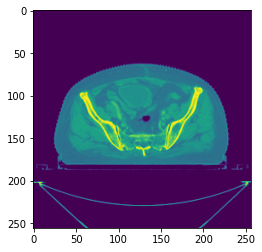

In [ ]:
image01 = image01.squeeze(0).cpu()
i_l = image01.squeeze(0).cpu().numpy()

plt.imshow(i_l[6,15,:,:])

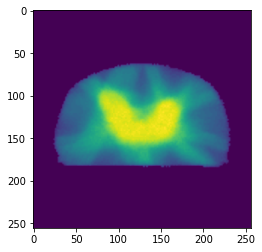

In [ ]:
image01_label = image01_label.squeeze(0).squeeze(0)
plt.imshow(image01_label[15,:,:])

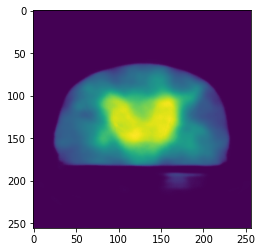

In [ ]:
pd = pred.squeeze(0).squeeze(0)
pd.shape
plt.imshow(pd[15,:,:])

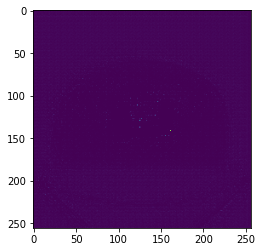

In [ ]:
pd2 = pred2.squeeze(0).squeeze(0)
pd2.shape
plt.imshow(pd2[15,:,:])

In [ ]:
# modelnew = torch.load('model.pkl')
# # modelnew.load_state_dict(checkpoint['model_state_dict'])
# modelnew.eval()


# inputall = np.load('data1\inputallstack\inputall_11111111_1.npy').astype(np.float32)
# inputct = np.load('data1\CTstack\CT_11111111_1.npy').astype(np.float32)
# inputall = transformer(inputall)
# inputct = transformer(inputct)


# inputall = inputall.unsqueeze(0)
# inputct = inputct.unsqueeze(0)
# input = torch.cat((inputall,inputct),0).unsqueeze(0)
# input.shape
# output = model(input)
# output.shape




modelnew = torch.load('model_SAVE\epoch482.pth')
# modelnew.load_state_dict(checkpoint['model_state_dict'])
modelnew.eval()


bladder_array = np.load('testdata\origininputstack\inputbladderstack\inputbladder_23512831_0.npy').astype(np.float32)
rectum_array = np.load('testdata\origininputstack\inputrectumstack\inputrectum_23512831_0.npy').astype(np.float32)
feml_array = np.load('testdata\origininputstack\inputfemlstack\inputfeml_23512831_0.npy').astype(np.float32)
femr_array = np.load('testdata\origininputstack\inputfemrstack\inputfemr_23512831_0.npy').astype(np.float32)
SI_array = np.load('testdata\origininputstack\inputSIstack\inputSI_23512831_0.npy').astype(np.float32)
PTV_array = np.load('testdata\origininputstack\inputPTVstack\inputPTV_23512831_0.npy').astype(np.float32)
BODY_array = np.load('testdata\origininputstack\inputBODYstack\inputBODY_23512831_0.npy').astype(np.float32)
ct_array = np.load('testdata\CTstack\CT_23512831_0.npy').astype(np.float32)


bladder_array = transformer(bladder_array)
rectum_array = transformer(rectum_array)
feml_array = transformer(feml_array)
femr_array = transformer(femr_array)
SI_array = transformer(SI_array)
PTV_array = transformer(PTV_array) 
BODY_array = transformer(BODY_array) 
ct_array = transformer(ct_array)
       

bladder_array = bladder_array.unsqueeze(0)
rectum_array = rectum_array.unsqueeze(0)
feml_array = feml_array.unsqueeze(0)
femr_array = femr_array.unsqueeze(0)
SI_array = SI_array.unsqueeze(0)
PTV_array = PTV_array.unsqueeze(0)
BODY_array = BODY_array.unsqueeze(0)
ct_array = ct_array.unsqueeze(0)
input = torch.cat((bladder_array,rectum_array,feml_array,femr_array,SI_array,PTV_array,BODY_array,ct_array),0).unsqueeze(0)

    
with torch.no_grad():
    image = input[0].unsqueeze(0).cuda()
    print(image.shape)
    pred = modelnew(image).cpu().numpy()        

pred.shape

AttributeError: 'dict' object has no attribute 'load_state_dict'

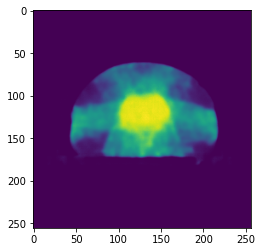

In [ ]:
pd = pred.squeeze(0).squeeze(0)
pd.shape
plt.imshow(pd[10,:,:])